In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval[all]
except Exception:
    pass

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer
from tensorflow.nn import relu

from dataeval.metrics.estimators import ber
from dataeval.utils.torch.datasets import MNIST

tf.keras.utils.set_random_seed(408)

In [3]:
# Load in both the training and testing mnist dataset
train_ds = MNIST(root="./data/", train=True, download=True, flatten=True)
test_ds = MNIST(root="./data/", train=False, download=True, channels="channels_last")

# Split out the images and labels for each set
images, labels = train_ds.data, train_ds.targets
test_images, test_labels = test_ds.data, test_ds.targets

Files already downloaded and verified


Files already downloaded and verified


In [4]:
print("Number of training samples: ", len(images))
print("Image shape:", images[0].shape)
print("Label counts: ", np.unique(labels, return_counts=True))

Number of training samples:  54210
Image shape: (784,)
Label counts:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421]))


In [5]:
images_split = {}
labels_split = {}

# Keep only 1, 4, and 9
for label in (1, 4, 9):
    subset_indices = np.where(labels == label)
    images_split[label] = images[subset_indices][:2000]
    labels_split[label] = labels[subset_indices][:2000]

images_subset = np.concatenate(list(images_split.values()))
labels_subset = np.concatenate(list(labels_split.values()))
print(images_subset.shape)
print(np.unique(labels_subset, return_counts=True))

(6000, 784)
(array([1, 4, 9], dtype=uint8), array([2000, 2000, 2000]))


In [6]:
# Evaluate the BER metric for the MNIST data with digits 1, 4, 9.
# One minus the value of this metric gives our estimate of the upper bound on accuracy.
base_result = ber(images_subset, labels_subset, method="MST")

In [7]:
print("The bayes error rate estimation:", base_result.ber)

The bayes error rate estimation: 0.025833333333333333


In [8]:
### TEST ASSERTION ###
print(base_result)

BEROutput(ber=0.025833333333333333, ber_lower=0.013044281629080704)


In [9]:
print("The maximum achievable accuracy:", (1 - base_result.ber) * 100)

The maximum achievable accuracy: 97.41666666666666


In [10]:
# Creates a binary mask where current label == 1 that can be used as the new labels
labels_merged = labels_subset == 1
print("New label counts:", np.unique(labels_merged, return_counts=True))

New label counts: (array([False,  True]), array([4000, 2000]))


In [11]:
# Evaluate the BER metric for the MNIST data with updated labels
new_result = ber(images_subset, labels_merged, method="MST")

In [12]:
print("The bayes error rate estimation:", new_result)

The bayes error rate estimation: BEROutput(ber=0.005, ber_lower=0.0025062814466900174)


In [13]:
### TEST ASSERTION ###
print(new_result)

BEROutput(ber=0.005, ber_lower=0.0025062814466900174)


In [14]:
print("The maximum achievable accuracy:", 1 - new_result.ber)

The maximum achievable accuracy: 0.995


In [15]:
# Build a simple CNN for classifying MNIST images.
model = Sequential(
    [
        InputLayer(input_shape=(28, 28, 1)),
        Conv2D(
            64,
            4,
            strides=2,
            padding="same",
            activation=relu,
        ),
        Conv2D(
            128,
            4,
            strides=2,
            padding="same",
            activation=relu,
        ),
        Conv2D(
            512,
            4,
            strides=2,
            padding="same",
            activation=relu,
        ),
        Flatten(),
        Dense(2),
    ]
)

I0000 00:00:1730837398.344259     815 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730837398.345425     815 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730837398.349387     815 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730837398.354186     815 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [16]:
test_indices = np.where((test_labels == 1) | (test_labels == 4) | (test_labels == 9))
test_images_subset = test_images[test_indices]
test_labels_subset = test_labels[test_indices]
test_labels_merged = test_labels_subset == 1

In [17]:
# Set up model hyperparameters
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Fitting a model may take a few minutes
history = model.fit(
    images_subset.reshape((-1, 28, 28, 1)),
    labels_merged,
    epochs=90,
    batch_size=32,
    steps_per_epoch=1,
    validation_data=(test_images_subset, test_labels_merged),
    verbose=0,
)

In [18]:
loss, accuracy = model.evaluate(test_images_subset, test_labels_merged, verbose=1)
print(f"The model accuracy: {accuracy*100:0.2f}%")

 1/84 [..............................] - ETA: 2s - loss: 0.0160 - accuracy: 1.0000

14/84 [====>.........................] - ETA: 0s - loss: 0.0378 - accuracy: 0.9866

27/84 [========>.....................] - ETA: 0s - loss: 0.0494 - accuracy: 0.9838

38/84 [============>.................] - ETA: 0s - loss: 0.0434 - accuracy: 0.9844

53/84 [=================>............] - ETA: 0s - loss: 0.0389 - accuracy: 0.9876

64/84 [=====================>........] - ETA: 0s - loss: 0.0343 - accuracy: 0.9893

78/84 [==========================>...] - ETA: 0s - loss: 0.0336 - accuracy: 0.9900

84/84 [==============================] - 0s 4ms/step - loss: 0.0315 - accuracy: 0.9907


The model accuracy: 99.07%


In [19]:
### TEST ASSERTION ###
print(accuracy)

0.9906576871871948


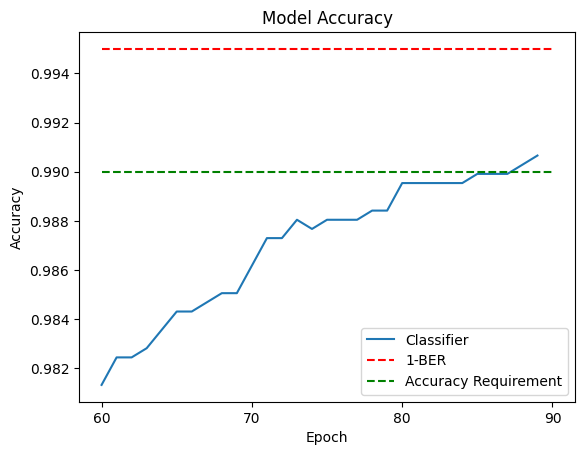

In [20]:
plt.title("Model Accuracy")
plt.plot(range(60, 90), np.array(history.history["val_accuracy"])[60:], label="Classifier")
plt.hlines(
    y=1 - new_result.ber,
    colors=["red"],
    xmin=60,
    xmax=90,
    label="1-BER",
    linestyles="dashed",
)
plt.hlines(
    y=0.99,
    colors=["green"],
    xmin=60,
    xmax=90,
    label="Accuracy Requirement",
    linestyles="dashed",
)

plt.xticks(range(60, 91, 10))
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc=4)